In [1]:
#!/usr/bin/env python
# coding: utf-8
import os
import re
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import datetime as dt
import xarray as xr
import matplotlib as mpl
import hydromt
from hydromt import DataCatalog
import hydromt_sfincs
from hydromt_sfincs import SfincsModel

In [2]:
# Filepath to data catalog yml
cat_dir = r'Z:\Data-Expansion\users\lelise\data'
yml_base_CONUS = os.path.join(cat_dir, 'data_catalog_BASE_CONUS.yml')
yml_base_Carolinas = os.path.join(cat_dir, 'data_catalog_BASE_Carolinas.yml')
yml_sfincs_Carolinas = os.path.join(cat_dir, 'data_catalog_SFINCS_Carolinas.yml')
root = r'Z:\Data-Expansion\users\lelise\projects\Carolinas_SFINCS\Chapter2_PGW\sfincs\01_AGU2023\future_florence\future_florence_ensmean'
mod = SfincsModel(root=root, mode='r', data_libs=[yml_base_CONUS, yml_base_Carolinas, yml_sfincs_Carolinas])
cat = mod.data_catalog
studyarea_gdf = mod.region.to_crs(epsg=32617)

In [3]:
# LOAD MODEL OUTPUTS
os.chdir(r'Z:\Data-Expansion\users\lelise\projects\Carolinas_SFINCS\Chapter2_PGW\sfincs\03_OBS\analysis_3')
da_zsmax = xr.open_dataset('pgw_zsmax.nc', engine='netcdf4')  # Max water level
da_vmax = xr.open_dataset('pgw_vmax.nc', engine='netcdf4')  # Max velocity
da_tmax = xr.open_dataset('pgw_tmax.nc', engine='netcdf4')  # Time of inundation
da_zsmax_class = xr.open_dataset(r'.\process_attribution\processes_classified.nc')
# Future ensemble mean
da_zsmax_ensmean = xr.open_dataset(r'.\ensemble_mean\fut_ensemble_zsmax_mean.nc')
da_zsmax_ensmean_class = xr.open_dataset(r'.\ensemble_mean\processes_classified_ensmean_mean.nc')
# ELEVATION DATA
dep = xr.open_dataset(r'Z:\Data-Expansion\users\lelise\projects\Carolinas_SFINCS\Chapter2_PGW\sfincs\subgrid\dep_subgrid_20m.tif')

# GUT RUN IDS FOR HURRICANE FLORENCE ONLY
run_ids = da_zsmax.run.values
subset_list = [r for r in run_ids if 'flor_fut' in r]
subset_list = [r for r in subset_list if 'compound' in r]
subset_list = [r for r in subset_list if 'SF8' not in r]
print(subset_list)

['flor_fut_SF1_SLR1_compound', 'flor_fut_SF1_SLR2_compound', 'flor_fut_SF1_SLR3_compound', 'flor_fut_SF1_SLR4_compound', 'flor_fut_SF1_SLR5_compound', 'flor_fut_SF2_SLR1_compound', 'flor_fut_SF2_SLR2_compound', 'flor_fut_SF2_SLR3_compound', 'flor_fut_SF2_SLR4_compound', 'flor_fut_SF2_SLR5_compound', 'flor_fut_SF3_SLR1_compound', 'flor_fut_SF3_SLR2_compound', 'flor_fut_SF3_SLR3_compound', 'flor_fut_SF3_SLR4_compound', 'flor_fut_SF3_SLR5_compound', 'flor_fut_SF4_SLR1_compound', 'flor_fut_SF4_SLR2_compound', 'flor_fut_SF4_SLR3_compound', 'flor_fut_SF4_SLR4_compound', 'flor_fut_SF4_SLR5_compound', 'flor_fut_SF5_SLR1_compound', 'flor_fut_SF5_SLR2_compound', 'flor_fut_SF5_SLR3_compound', 'flor_fut_SF5_SLR4_compound', 'flor_fut_SF5_SLR5_compound', 'flor_fut_SF6_SLR1_compound', 'flor_fut_SF6_SLR2_compound', 'flor_fut_SF6_SLR3_compound', 'flor_fut_SF6_SLR4_compound', 'flor_fut_SF6_SLR5_compound', 'flor_fut_SF7_SLR1_compound', 'flor_fut_SF7_SLR2_compound', 'flor_fut_SF7_SLR3_compound', 'flor_fut

In [4]:
buildings = pd.read_csv(r'Z:\Data-Expansion\users\lelise\projects\Carolinas_SFINCS\Chapter2_PGW\sfincs\03_OBS\analysis_3\infrastructure_exposure\florence_buildings_exposed.csv', index_col=0)
buildings = buildings.drop('geometry', axis=1)

gdf = gpd.GeoDataFrame(buildings, geometry=gpd.points_from_xy(x=buildings['xcoords'].values, y=buildings['ycoords'].values, crs=32617))
gdf['pres_zsmax_class'][(gdf['pres_zsmax_class'] == 2) | (gdf['pres_zsmax_class'] == 4)] = 5
gdf['fut_zsmax_class'][(gdf['fut_zsmax_class'] == 2) | (gdf['fut_zsmax_class'] == 4)] = 5

In [5]:
hmin = 0.64
gdf = gdf[(gdf['fut_depth'] > hmin) | (gdf['pres_depth'] > hmin)]
print(gdf['depth_diff'].describe())

count    100689.000000
mean          0.922370
std           0.273759
min           0.000000
25%           0.705000
50%           0.916000
75%           1.160000
max           3.100000
Name: depth_diff, dtype: float64


In [6]:
# Get locations where process classifcation changes from present to future
counts = gdf[['pres_zsmax_class', 'fut_zsmax_class']].value_counts().reset_index(name='count')
print(counts)

pcode, pres_counts = np.unique(gdf['pres_zsmax_class'], return_counts=True)
print(pcode)
print(pres_counts)

pcode, fut_counts = np.unique(gdf['fut_zsmax_class'], return_counts=True)
print(pcode)
print(fut_counts)

   pres_zsmax_class  fut_zsmax_class  count
0                 5                5  36095
1                 3                3  23189
2                 3                5  20607
3                 1                1  15708
4                 3                1   2147
5                 5                1   1670
6                 1                5   1266
7                 0                1     82
8                 5                3     41
9                 0                5      2
[0 1 3 5]
[   84 16974 45943 37806]
[1 3 5]
[19607 23230 57970]


In [7]:
font = {'family': 'Arial', 'size': 10}
mpl.rc('font', **font)
mpl.rcParams.update({'axes.titlesize': 10})

pres_color = 'blue'
fut_color = 'orange'
scenarios = ['Runoff', 'Coastal', 'Compound', 'Total']
class_ids = [3, 1, 5, -999]
mae = 0.64
hmin = 0.0
gdf_mae = gdf.copy()
gdf_mae['pres_depth']  = gdf_mae['pres_depth'] - mae
gdf_mae['fut_depth']  = gdf_mae['fut_depth'] - mae

present = gdf_mae[gdf_mae['pres_depth'] > hmin]
future = gdf_mae[gdf_mae['fut_depth'] > hmin]

In [8]:
print(present.describe())

             xcoords       ycoords    pres_zsmax     fut_zsmax      gnd_elev  \
count   41333.000000  4.133300e+04  41333.000000  41333.000000  41333.000000   
mean   800905.031030  3.853286e+06      8.414698      9.248866      6.995691   
std     88811.642859  6.792227e+04     11.682860     11.580974     11.734528   
min    554605.014000  3.686135e+06      0.497000      1.423000     -8.068000   
25%    690700.457000  3.809905e+06      2.651000      3.430000      1.299000   
50%    832736.770000  3.879637e+06      3.503000      4.216000      2.241000   
75%    875119.856000  3.901069e+06      7.139000      8.100000      5.801000   
max    999726.361000  4.004857e+06    218.871000    219.645000    217.966000   

          fut_depth    pres_depth    depth_diff     pres_vmax      fut_vmax  \
count  41333.000000  41333.000000  41333.000000  41333.000000  41333.000000   
mean       1.613176      0.779010      0.834167      0.226228      0.257301   
std        0.943356      0.850033      0.2

In [9]:
print(future.describe())

            xcoords       ycoords     pres_zsmax      fut_zsmax  \
count  1.008070e+05  1.008070e+05  100689.000000  100807.000000   
mean   8.057290e+05  3.842236e+06       7.011385       7.926482   
std    9.400923e+04  7.078011e+04      11.198349      11.075920   
min    5.339476e+05  3.678432e+06       0.250000       0.989000   
25%    6.951281e+05  3.790065e+06       1.621000       2.658000   
50%    8.220574e+05  3.851769e+06       3.235000       3.978000   
75%    8.875820e+05  3.897159e+06       5.210000       6.259000   
max    1.000456e+06  4.005984e+06     218.871000     219.645000   

            gnd_elev     fut_depth     pres_depth     depth_diff  \
count  100807.000000  100807.00000  100689.000000  100689.000000   
mean        6.367512       0.91897      -0.002460       0.922370   
std        11.128450       0.86942       0.886562       0.273759   
min        -8.068000       0.00100      -2.398000       0.000000   
25%         1.302000       0.31500      -0.601000       

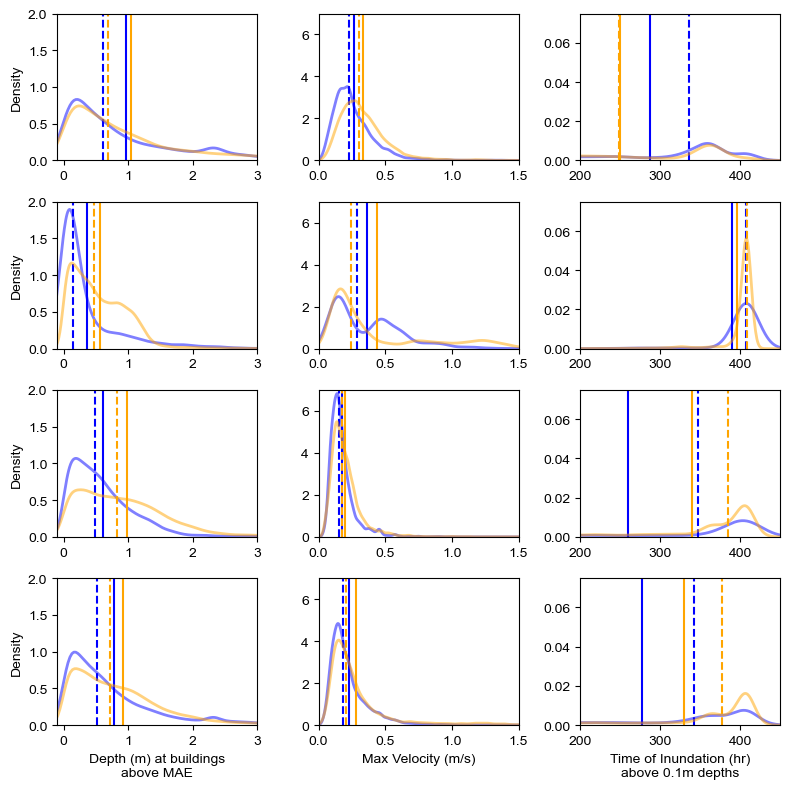

In [10]:
nrow = 4
ncol = 3
n_subplots = nrow * ncol
first_in_row = np.arange(0, n_subplots, ncol)
last_in_row = np.arange(ncol - 1, n_subplots, ncol)
first_row = np.arange(0, ncol)
last_row = np.arange(first_in_row[-1], n_subplots, 1)

fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(8, 8), tight_layout=True, sharex=False, sharey=False)

for i in range(len(scenarios)):
    class_id = int(class_ids[i])
    if class_id != -999:
        pres = present[present['pres_zsmax_class'] == class_id]
        fut = future[future['fut_zsmax_class'] == class_id]
    else:
        pres = present[present['pres_zsmax_class'] > 0]
        fut = future[future['fut_zsmax_class'] > 0]

    # Depth
    ax = axs[i][0]
    d1 = pres['pres_depth']
    d2 = fut['fut_depth']
    
    d1.plot(kind='density', ax=ax, alpha=0.5, label=f'Present (n={len(d1)})', linewidth=2, color=pres_color)
    ax.axvline(d1.mean(), linestyle='solid', linewidth=1.5, color=pres_color, label='Present Mean')
    ax.axvline(d1.median(), linestyle='dashed', linewidth=1.5, color=pres_color, alpha=1, label='Present Median')
    
    d2.plot(kind='density', ax=ax, alpha=0.5, label=f'Future (n={len(d2)})', linewidth=2, color=fut_color)
    ax.axvline(d2.mean(), linestyle='solid', linewidth=1.5, color=fut_color, label='Future Mean')
    ax.axvline(d2.median(), linestyle='dashed', linewidth=1.5, color=fut_color, alpha=1, label='Future Median')

    ax.set_ylim(0, 2)
    ax.set_xlim(-0.1, 3)
    ax.set_ylabel('')
    ax.set_xlabel('')

    # Velocity
    ax = axs[i][1]
    d1 = pres['pres_vmax']
    d2 = fut['fut_vmax']
    
    d1.plot(kind='density', ax=ax, alpha=0.5, label=f'Present (n={len(d1)})', linewidth=2, color=pres_color)
    ax.axvline(d1.mean(), linestyle='solid', linewidth=1.5, color=pres_color, label='Present Mean')
    ax.axvline(d1.median(), linestyle='dashed', linewidth=1.5, color=pres_color, alpha=1, label='Present Median')
    
    d2.plot(kind='density', ax=ax, alpha=0.5, label=f'Future (n={len(d2)})', linewidth=2, color=fut_color)
    ax.axvline(d2.mean(), linestyle='solid', linewidth=1.5, color=fut_color, label='Future Mean')
    ax.axvline(d2.median(), linestyle='dashed', linewidth=1.5, color=fut_color, alpha=1, label='Future Median')
    
    ax.set_ylim(0, 7)
    ax.set_xlim(0, 1.5)
    ax.set_ylabel('')
    ax.set_xlabel('')

    # Tmax
    ax = axs[i][2]
    d1 = pres['pres_tmax']
    d2 = fut['fut_tmax']
    
    d1.plot(kind='density', ax=ax, alpha=0.5, label=f'Present (n={len(d1)})', linewidth=2, color=pres_color)
    ax.axvline(d1.mean(), linestyle='solid', linewidth=1.5, color=pres_color, label='Present Mean')
    ax.axvline(d1.median(), linestyle='dashed', linewidth=1.5, color=pres_color, alpha=1, label='Present Median')
    
    d2.plot(kind='density', ax=ax, alpha=0.5, label=f'Future (n={len(d2)})', linewidth=2, color=fut_color)
    ax.axvline(d2.mean(), linestyle='solid', linewidth=1.5, color=fut_color, label='Future Mean')
    ax.axvline(d2.median(), linestyle='dashed', linewidth=1.5, color=fut_color, alpha=1, label='Future Median')
    
    ax.set_ylim(0, 0.075)
    ax.set_xlim(200, 450)
    ax.set_ylabel('')
    ax.set_xlabel('')

axs[0][0].set_ylabel('Density')
axs[1][0].set_ylabel('Density') 
axs[2][0].set_ylabel('Density')
axs[3][0].set_ylabel('Density') 

axs[3][1].set_xlabel('Max Velocity (m/s)')
axs[3][0].set_xlabel(f'Depth (m) at buildings\nabove MAE')
axs[3][2].set_xlabel(f'Time of Inundation (hr)\nabove 0.1m depths')

#for i in range(len(scenarios)):
    #axs[i][0].text(-1.5, 1, scenarios[i], horizontalalignment='right', verticalalignment='center', rotation='horizontal')

#plt.subplots_adjust(wspace=0.05, hspace=0.02)
plt.margins(x=0, y=0)
#plt.savefig(r'Z:\Data-Expansion\users\lelise\projects\Carolinas_SFINCS\Chapter2_PGW\sfincs\03_OBS\analysis_3\infrastructure_exposure\building_exposure_Florence.jpg', dpi=300, bbox_inches="tight")

In [11]:
import matplotlib.dates as mdates
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime, timedelta
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs

load_geo_layers = True
if load_geo_layers is True:
    coastal_wb = mod.data_catalog.get_geodataframe('carolinas_coastal_wb')
    coastal_wb = coastal_wb.to_crs(mod.crs)
    coastal_wb_clip = coastal_wb.clip(mod.region)

    major_rivers = mod.data_catalog.get_geodataframe('carolinas_nhd_area_rivers')
    major_rivers = major_rivers.to_crs(mod.crs)
    major_rivers_clip = major_rivers.clip(mod.region)

    nc_major_rivers = mod.data_catalog.get_geodataframe('carolinas_major_rivers')
    nc_major_rivers = nc_major_rivers.to_crs(mod.crs)
    nc_major_rivers_clip = nc_major_rivers.clip(mod.region)

    urban_areas = gpd.read_file(r'Z:\Data-Expansion\users\lelise\data\geospatial\boundary\2010_Census_Urban_Areas\2010_Census_Urban_Areas.shp').to_crs(32617)
    urban_areas = urban_areas.clip(mod.region)

    tc_tracks = cat.get_geodataframe(r'Z:\Data-Expansion\users\lelise\data\geospatial\hurricane_tracks\IBTrACS.NA.list'
                                     r'.v04r00.lines\IBTrACS.NA.list.v04r00.lines.shp')
    tc_tracks.to_crs(epsg=32617, inplace=True)

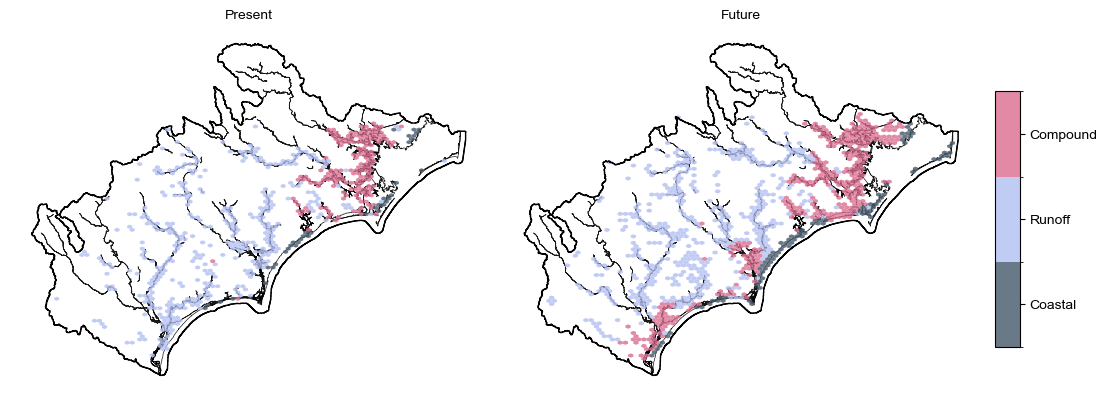

In [12]:
# MAP THE STATS
da = mod.grid['dep']
wkt = da.raster.crs.to_wkt()
utm_zone = da.raster.crs.to_wkt().split("UTM zone ")[1][:3]
utm = ccrs.UTM(int(utm_zone[:2]), "S" in utm_zone)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4.5), subplot_kw={'projection': utm}, tight_layout=True)
axs = axs.flatten()
dplt = [present, future]
vplt = ['pres_zsmax_class', 'fut_zsmax_class']
clim = ['Present', 'Future']
for i in range(len(axs)):
    ax = axs[i]
    d = dplt[i]
    cmap = mpl.colors.ListedColormap(['#4F6272', '#B7C3F3', '#DD7596'])
    bounds = [0, 2, 4, 6]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='neither')
    hb = ax.hexbin(d['xcoords'], d['ycoords'], C=d[vplt[i]],
                   mincnt = 5, 
                   #marginals=True,
                   gridsize=80, 
                   cmap=cmap, norm=norm, 
                   alpha=0.85, edgecolors='none', linewidth=0.1, zorder=1)
    major_rivers_clip.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5, zorder=0, alpha=0.9)
    nc_major_rivers_clip.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5, zorder=0, alpha=0.9)
    coastal_wb_clip.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5, zorder=0, alpha=0.9)
    mod.region.plot(ax=ax, color='none', edgecolor='black', linewidth=1, zorder=1, alpha=1)
    ax.set_title(clim[i])
    ax.set_axis_off()

pos0 = axs[1].get_position()  # get the original position
cax1 = fig.add_axes([pos0.x1 + 0.015, pos0.y0 + 0.1, 0.025, pos0.height * 0.7])
cbar1 = fig.colorbar(hb,
                     cax=cax1,
                     orientation='vertical',
                     ticks=[1, 3, 5],
                     #label='Flood Process'
                    )
cbar1.ax.set_yticklabels(labels=['Coastal', 'Runoff', 'Compound'])

plt.subplots_adjust(wspace=0.0, hspace=0.0)
plt.margins(x=0, y=0)
#plt.savefig(r'Z:\Data-Expansion\users\lelise\projects\Carolinas_SFINCS\Chapter2_PGW\sfincs\03_OBS\analysis_3\infrastructure_exposure\building_exposure_FldProc_Florence_minCnt5_gridsize80.jpg', dpi=300, bbox_inches="tight")

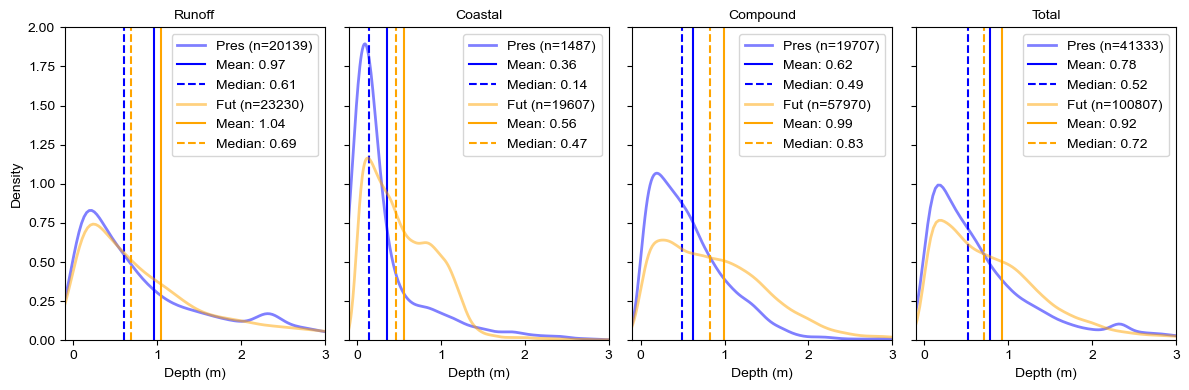

In [13]:
nrow = 1
ncol = 4
n_subplots = nrow * ncol
first_in_row = np.arange(0, n_subplots, ncol)
last_in_row = np.arange(ncol - 1, n_subplots, ncol)
first_row = np.arange(0, ncol)
last_row = np.arange(first_in_row[-1], n_subplots, 1)
building_numbers_present = []
building_numbers_future = []

fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(12, 4), tight_layout=True, sharex=True, sharey=True)
axs=axs.flatten()
for i in range(len(scenarios)):
    class_id = int(class_ids[i])
    if class_id != -999:
        pres = present[present['pres_zsmax_class'] == class_id]
        fut = future[future['fut_zsmax_class'] == class_id]
    else:
        pres = present[present['pres_zsmax_class'] > 0]
        fut = future[future['fut_zsmax_class'] > 0]

    # Depth
    ax = axs[i]
    d1 = pres['pres_depth']
    d2 = fut['fut_depth']
    building_numbers_present.append(len(d1))
    building_numbers_future.append(len(d2))
    
    d1.plot(kind='density', ax=ax, alpha=0.5, label=f'Pres (n={len(d1)})', linewidth=2, color=pres_color)
    ax.axvline(d1.mean(), linestyle='solid', linewidth=1.5, color=pres_color, label=f'Mean: {np.round(d1.mean(),2)}')
    ax.axvline(d1.median(), linestyle='dashed', linewidth=1.5, color=pres_color, alpha=1, label=f'Median: {np.round(d1.median(),2)}')
    
    d2.plot(kind='density', ax=ax, alpha=0.5, label=f'Fut (n={len(d2)})', linewidth=2, color=fut_color)
    ax.axvline(d2.mean(), linestyle='solid', linewidth=1.5, color=fut_color, label=f'Mean: {np.round(d2.mean(),2)}')
    ax.axvline(d2.median(), linestyle='dashed', linewidth=1.5, color=fut_color, alpha=1, label=f'Median: {np.round(d2.median(),2)}')

    ax.set_ylim(0, 2)
    ax.set_xlim(-0.1, 3)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.legend(loc='best')
    ax.set_title(scenarios[i])
    ax.set_xlabel(f'Depth (m)')
    ax.set_ylabel('Density')


plt.subplots_adjust(wspace=0.05, hspace=0.02)
plt.margins(x=0, y=0)
#plt.savefig(r'Z:\Data-Expansion\users\lelise\projects\Carolinas_SFINCS\Chapter2_PGW\sfincs\03_OBS\analysis_3\infrastructure_exposure\building_exposure_Florence_depth.jpg', dpi=300, bbox_inches="tight")

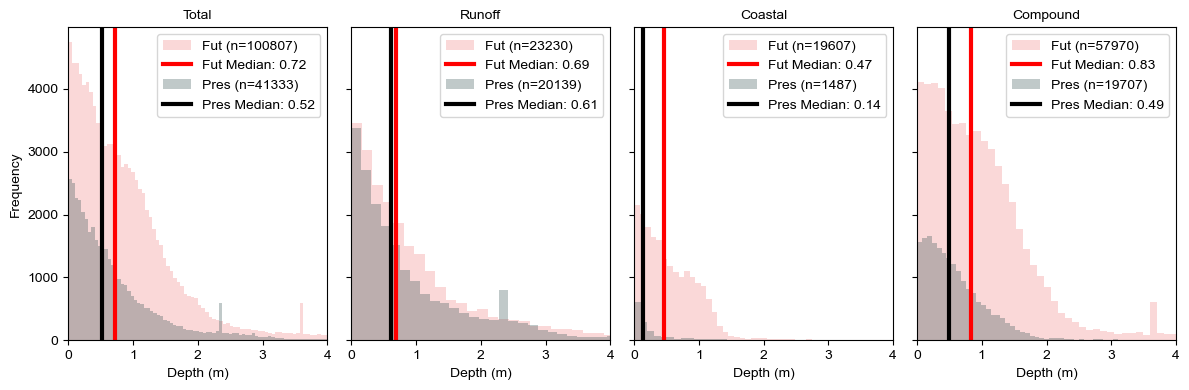

In [15]:
nrow = 1
ncol = 4
n_subplots = nrow * ncol
first_in_row = np.arange(0, n_subplots, ncol)
last_in_row = np.arange(ncol - 1, n_subplots, ncol)
first_row = np.arange(0, ncol)
last_row = np.arange(first_in_row[-1], n_subplots, 1)
building_numbers_present = []
building_numbers_future = []
pres_color = 'darkslategrey'
fut_color = 'lightcoral'
scenarios = ['Total','Runoff', 'Coastal', 'Compound']
binss = [ 300, 100, 50, 100]
class_ids = [-999, 3, 1, 5]

fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(12, 4), tight_layout=True, sharex=True, sharey=True)
axs=axs.flatten()
for i in range(len(scenarios)):
    class_id = int(class_ids[i])
    if class_id != -999:
        pres = present[present['pres_zsmax_class'] == class_id]
        fut = future[future['fut_zsmax_class'] == class_id]
    else:
        pres = present[present['pres_zsmax_class'] > 0]
        fut = future[future['fut_zsmax_class'] > 0]

    # Depth
    ax = axs[i]
    d1 = pres['pres_depth']
    d2 = fut['fut_depth']
    building_numbers_present.append(len(d1))
    building_numbers_future.append(len(d2))
    
    ax.hist(d2, alpha=0.3, bins=binss[i], label=f'Fut (n={len(d2)})', linewidth=2, color=fut_color)
    #ax.axvline(d2.mean(), linestyle='solid', linewidth=1.5, color=fut_color, label=f'Mean: {np.round(d2.mean(),2)}')
    ax.axvline(d2.median(), linestyle='solid', linewidth=3, color='red', alpha=1, label=f'Fut Median: {np.round(d2.median(),2)}')

    ax.hist(d1, alpha=0.3, bins=binss[i], label=f'Pres (n={len(d1)})', linewidth=2, color=pres_color)
    #ax.axvline(d1.mean(), linestyle='solid', linewidth=1.5, color=pres_color, label=f'Mean: {np.round(d1.mean(),2)}')
    ax.axvline(d1.median(), linestyle='solid', linewidth=3, color='black', alpha=1, label=f'Pres Median: {np.round(d1.median(),2)}')

    #ax.set_ylim(0, 2)
    ax.set_xlim(0, 4)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.legend(loc='best')
    ax.set_title(scenarios[i])
    ax.set_xlabel(f'Depth (m)')
    if i == 0:
        ax.set_ylabel('Frequency')


plt.subplots_adjust(wspace=0.05, hspace=0.02)
plt.margins(x=0, y=0)
plt.savefig(r'Z:\Data-Expansion\users\lelise\projects\Carolinas_SFINCS\Chapter2_PGW\sfincs\03_OBS\analysis_3\infrastructure_exposure\building_exposure_Florence_depth_v2.jpg', dpi=300, bbox_inches="tight")

In [66]:
tots = pd.DataFrame()
tots['Present'] = building_numbers_present
tots['Future'] = building_numbers_future
tots = tots.T
tots.columns = scenarios
print(tots)

         Runoff  Coastal  Compound   Total
Present   20139     1487     19707   41333
Future    23230    19607     57970  100807


         Runoff  Coastal  Compound
Present   20139     1487     19707
Future    23230    19607     57970


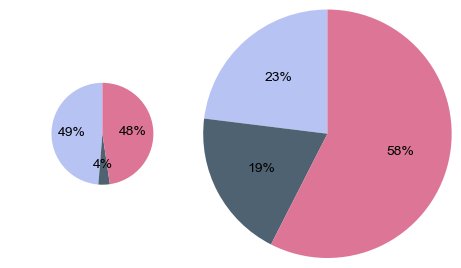

In [76]:
# Setup Plot Info
combined = tots.drop('Total', axis=1)
print(combined)
pie_scale = combined.sum(axis=1) / 60000

colors = [ '#B7C3F3', '#4F6272', '#DD7596', '#8EB897']
nrow, ncol = 1, 2
n_subplots = nrow * ncol
first_in_row = np.arange(0, n_subplots, ncol)
last_row = np.arange(n_subplots - ncol, n_subplots, 1)
fig, axs = plt.subplots(nrows=nrow,
                        ncols=ncol,
                        figsize=(4.5, 4.5),
                        tight_layout=True,
                        layout='constrained'
                        )
axs = axs.flatten()
for i in range(len(tots.index)):
    ax = axs[i]
    d = combined[combined.index == combined.index[i]]
    ax.pie(d.to_numpy()[0],
           colors=colors,
           radius=pie_scale[pie_scale.index == combined.index[i]][0],
           startangle=90,
           autopct='%1.0f%%',
           )
#axs[0].set_title('Present')
#axs[1].set_title('Future')
#legend_kwargs0 = dict(
#    bbox_to_anchor=(2.2, 0.8),
#    title=None,
#    loc="upper right",
#    frameon=True,
#    prop=dict(size=10),
#)
#axs[1].legend(labels=combined.columns, **legend_kwargs0)
plt.subplots_adjust(wspace=0.0, hspace=0.05)
plt.margins(x=0, y=0)
plt.savefig(r'Z:\Data-Expansion\users\lelise\projects\Carolinas_SFINCS\Chapter2_PGW\sfincs\03_OBS\analysis_3\infrastructure_exposure\fld_build_pieChart_ensmean_v2.jpg', bbox_inches='tight', dpi=300)